# Target Problem

The project proposes to use a deep reinforcement learning framework to learn a profitable stock trading strategy, with the goal to optimize the cumulative return and Alpha. It would select S&P500 Index with the top 20 market capitalization stocks as our trading stock pool. The input to the algorithm is the market trend for these stocks in the last month, remaining balance, and current portfolio. The model agent output is a series of trading actions among stocks. The available trading
action options are: sell, buy and hold. The market data in the most recent months will be used to feed
the model performance evaluation.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:

* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: SP500 top 20 companies


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


## Environment Setup

### Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta

%matplotlib inline
from rl.config import config
from rl.marketdata.yahoodownloader import YahooDownloader
from rl.preprocessing.preprocessors import FeatureEngineer
from rl.preprocessing.data import data_split
from rl.env.env_stocktrading import StockTradingEnv
from rl.model.models import DRLAgent
from rl.trade.backtest import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import itertools

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


### Cache Folders

In [2]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

### Fetch Data

In [3]:
# from config.py start_date is a string
start_date = config.START_DATE
# from config.py end_date is a string
end_date = config.END_DATE
# from config.py split_date is a string
split_date = config.SPLIT_DATE
# config target ticker
target_ticker = config.SP500_20_TICKER
# config tech_indicator_list
tech_indicator_list = config.TECHNICAL_INDICATORS_LIST
print("training period: {}-{}, testing period: {}-{}\n".format(start_date, split_date, split_date, end_date))
print("target ticker list:\n {}\n".format(target_ticker))
print("tech_indicator_list:\n {}\n".format(tech_indicator_list))

training period: 2000-01-01-2019-01-01, testing period: 2019-01-01-2021-01-01

target ticker list:
 ['AAPL', 'MSFT', 'AMZN', 'BRK-B', 'JPM', 'JNJ', 'UNH', 'HD', 'PG', 'NVDA', 'DIS', 'BAC', 'CMCSA', 'XOM', 'VZ', 'T', 'ADBE', 'PFE', 'CSCO', 'INTC']

tech_indicator_list:
 ['macd', 'boll_ub', 'boll_lb', 'rsi_10', 'rsi_20', 'cci_10', 'cci_20', 'dx_30', 'close_20_sma', 'close_60_sma', 'close_120_sma', 'close_20_ema', 'close_60_ema', 'close_120_ema']



In [4]:
df = YahooDownloader(start_date = start_date,
                     end_date = end_date,
                     ticker_list = target_ticker).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [5]:
df.shape

(105680, 8)

In [6]:
df.sort_values(['date','tic'],ignore_index=True).head()

,date,open,high,low,close,volume,tic,day
0,2000-01-03,0.936384,1.004464,0.907924,0.859423,535796800.0,AAPL,0
1,2000-01-03,16.812500,16.875000,16.062500,16.274673,7384400.0,ADBE,0
2,2000-01-03,81.500000,89.562500,79.046875,89.375000,16117600.0,AMZN,0
3,2000-01-03,25.125000,25.125000,24.000000,13.952057,13705800.0,BAC,0
4,2000-01-03,36.500000,36.580002,34.820000,35.299999,875000.0,BRK-B,0


## Data Preprocessing
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

### Feature Engineering

In [7]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = tech_indicator_list,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

Successfully added technical indicators
Successfully added turbulence index


In [8]:
print(processed.shape)
processed.head()

(105680, 23)


,date,open,high,low,close,volume,tic,day,macd,boll_ub,...,cci_10,cci_20,dx_30,close_20_sma,close_60_sma,close_120_sma,close_20_ema,close_60_ema,close_120_ema,turbulence
0,2000-01-03,0.936384,1.004464,0.907924,0.859423,535796800.0,AAPL,0,0.0,0.925665,...,-66.666667,-66.666667,100.0,0.859423,0.859423,0.859423,0.859423,0.859423,0.859423,0.0
1,2000-01-03,16.812500,16.875000,16.062500,16.274673,7384400.0,ADBE,0,0.0,0.925665,...,-66.666667,-66.666667,100.0,16.274673,16.274673,16.274673,16.274673,16.274673,16.274673,0.0
2,2000-01-03,81.500000,89.562500,79.046875,89.375000,16117600.0,AMZN,0,0.0,0.925665,...,-66.666667,-66.666667,100.0,89.375000,89.375000,89.375000,89.375000,89.375000,89.375000,0.0
3,2000-01-03,25.125000,25.125000,24.000000,13.952057,13705800.0,BAC,0,0.0,0.925665,...,-66.666667,-66.666667,100.0,13.952057,13.952057,13.952057,13.952057,13.952057,13.952057,0.0
4,2000-01-03,36.500000,36.580002,34.820000,35.299999,875000.0,BRK-B,0,0.0,0.925665,...,-66.666667,-66.666667,100.0,35.299999,35.299999,35.299999,35.299999,35.299999,35.299999,0.0


### Data display

In [9]:
list_ticker = processed["tic"].unique().tolist()
print(list_ticker)
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))
processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])
processed_full = processed_full.fillna(0)

['AAPL', 'ADBE', 'AMZN', 'BAC', 'BRK-B', 'CMCSA', 'CSCO', 'DIS', 'HD', 'INTC', 'JNJ', 'JPM', 'MSFT', 'NVDA', 'PFE', 'PG', 'T', 'UNH', 'VZ', 'XOM']


In [10]:
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

,date,tic,open,high,low,close,volume,day,macd,boll_ub,...,cci_10,cci_20,dx_30,close_20_sma,close_60_sma,close_120_sma,close_20_ema,close_60_ema,close_120_ema,turbulence
0,2000-01-03,AAPL,0.936384,1.004464,0.907924,0.859423,535796800.0,0.0,0.0,0.925665,...,-66.666667,-66.666667,100.0,0.859423,0.859423,0.859423,0.859423,0.859423,0.859423,0.0
1,2000-01-03,ADBE,16.812500,16.875000,16.062500,16.274673,7384400.0,0.0,0.0,0.925665,...,-66.666667,-66.666667,100.0,16.274673,16.274673,16.274673,16.274673,16.274673,16.274673,0.0
2,2000-01-03,AMZN,81.500000,89.562500,79.046875,89.375000,16117600.0,0.0,0.0,0.925665,...,-66.666667,-66.666667,100.0,89.375000,89.375000,89.375000,89.375000,89.375000,89.375000,0.0
3,2000-01-03,BAC,25.125000,25.125000,24.000000,13.952057,13705800.0,0.0,0.0,0.925665,...,-66.666667,-66.666667,100.0,13.952057,13.952057,13.952057,13.952057,13.952057,13.952057,0.0
4,2000-01-03,BRK-B,36.500000,36.580002,34.820000,35.299999,875000.0,0.0,0.0,0.925665,...,-66.666667,-66.666667,100.0,35.299999,35.299999,35.299999,35.299999,35.299999,35.299999,0.0
5,2000-01-03,CMCSA,16.145832,16.333332,15.062500,12.189544,2333700.0,0.0,0.0,0.925665,...,-66.666667,-66.666667,100.0,12.189544,12.189544,12.189544,12.189544,12.189544,12.189544,0.0
6,2000-01-03,CSCO,54.968750,55.125000,51.781250,40.118656,53076000.0,0.0,0.0,0.925665,...,-66.666667,-66.666667,100.0,40.118656,40.118656,40.118656,40.118656,40.118656,40.118656,0.0
7,2000-01-03,DIS,28.855125,29.533344,28.361876,23.115248,8402230.0,0.0,0.0,0.925665,...,-66.666667,-66.666667,100.0,23.115248,23.115248,23.115248,23.115248,23.115248,23.115248,0.0
8,2000-01-03,HD,68.625000,69.187500,63.812500,42.563168,12030800.0,0.0,0.0,0.925665,...,-66.666667,-66.666667,100.0,42.563168,42.563168,42.563168,42.563168,42.563168,42.563168,0.0
9,2000-01-03,INTC,41.632812,43.687500,41.625000,27.002798,57710200.0,0.0,0.0,0.925665,...,-66.666667,-66.666667,100.0,27.002798,27.002798,27.002798,27.002798,27.002798,27.002798,0.0


### Data Split

In [11]:
train = data_split(processed_full, start_date, split_date)
evaluate = data_split(processed_full, split_date, end_date)
print(train.shape)
print(evaluate.shape)

(95580, 23)
(10100, 23)


## RL Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

In [12]:
#initialData = train.loc[0,:]

In [13]:
#evaluate.head()

In [14]:
stock_dimension = len(processed_full.tic.unique())
state_space = 1 + 2*stock_dimension + len(tech_indicator_list)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 20, State Space: 321


In [149]:
env_params = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "buy_cost_pct": 0.001,
    "sell_cost_pct": 0.001,
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": tech_indicator_list, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-6
}
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.0002,
    "batch_size": 128,
}
TD3_PARAMS = {
    "batch_size": 100, 
    "buffer_size": 1000000, 
    "learning_rate": 0.001
}
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 1000000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}
total_timesteps = 1

In [150]:
def predict_train(model_name, env_params, model_kwargs, total_timesteps):
    train = data_split(processed_full, start_date, split_date)
    e_train_gym = StockTradingEnv(df = train, **env_params)
    # Environment for training
    env_train, _ = e_train_gym.get_sb_env()
    print(type(env_train))
    # Train model
    agent = DRLAgent(env = env_train)
    if model_name == 'a2c' || model_name == 'ddpg':
        model = agent.get_model(model_name)
    else:
        model = agent.get_model(model_name, model_kwargs = model_kwargs)  
    
    trained_model = agent.train_model(
        model=model, 
        tb_log_name=model_name,
        total_timesteps=total_timesteps)

    df_value, df_actions = dict(), dict()
    df_value['training_'+model_name], df_actions['training_'+model_name] = DRLAgent.DRL_prediction(trained_model, e_train_gym)
    
    return df_value, df_actions    

In [151]:
def rolling_prediction_month(model_name, dataset, predict_time_period, env_params, model_kwargs, total_timesteps):
    # Split data
    period = datetime.strptime(predict_time_period, "%Y-%m") #2019-01
    monthFirstDate = period.replace(day=1)
    if monthFirstDate.month == 12:
        nextMonthFirstDate = monthFirstDate.replace(year=monthFirstDate.year+1, month=1)
    else:
        nextMonthFirstDate = monthFirstDate.replace(month=monthFirstDate.month+1)
    train = data_split(processed_full, start_date, monthFirstDate.strftime("%Y-%m-%d"))
    evaluate = data_split(processed_full, monthFirstDate.strftime("%Y-%m-%d"), nextMonthFirstDate.strftime("%Y-%m-%d"))
    e_train_gym = StockTradingEnv(df = train, **env_params)
    e_evaluation_gym = StockTradingEnv(df=evaluate, **env_params)
    # Environment for training
    env_train, _ = e_train_gym.get_sb_env()
    print(type(env_train))
    # Train model
    agent = DRLAgent(env = env_train)
    if model_name == 'a2c' || model_name == 'ddpg':
        model = agent.get_model(model_name)
    else:
        model = agent.get_model(model_name, model_kwargs = model_kwargs)  
    
    trained_model = agent.train_model(
        model=model, 
        tb_log_name=model_name,
        total_timesteps=total_timesteps)

    df_value, df_actions = dict(), dict()
    #df_value['training_'+model_name], df_actions['training_'+model_name] = DRLAgent.DRL_prediction(trained_model, e_train_gym)
    df_value['evaluation_'+model_name], df_actions['evaluation_'+model_name] = DRLAgent.DRL_prediction(trained_model, e_evaluation_gym)
    
    return df_value, df_actions


In [152]:
def rolling_prediction_quarter(model_name, dataset, predict_time_period, env_params, model_kwargs, total_timesteps):
    # Split data
    period = datetime.strptime(predict_time_period, "%Y-%m") #2019-01
    monthFirstDate = period.replace(day=1)
    if monthFirstDate.month >= 10:
        nextQuarterFirstDate = monthFirstDate.replace(year=monthFirstDate.year+1, month=(monthFirstDate.month + 3)%12)
    else:
        nextQuarterFirstDate = monthFirstDate.replace(month=monthFirstDate.month+3)
    train = data_split(processed_full, start_date, monthFirstDate.strftime("%Y-%m-%d"))
    evaluate = data_split(processed_full, monthFirstDate.strftime("%Y-%m-%d"), nextQuarterFirstDate.strftime("%Y-%m-%d"))
    e_train_gym = StockTradingEnv(df = train, **env_params)
    e_evaluation_gym = StockTradingEnv(df=evaluate, **env_params)
    # Environment for training
    env_train, _ = e_train_gym.get_sb_env()
    print(type(env_train))
    # Train model
    agent = DRLAgent(env = env_train)
    if model_name == 'a2c' || model_name == 'ddpg':
        model = agent.get_model(model_name)
    else:
        model = agent.get_model(model_name, model_kwargs = model_kwargs)  
    
    trained_model = agent.train_model(
        model=model, 
        tb_log_name=model_name,
        total_timesteps=total_timesteps)

    df_value, df_actions = dict(), dict()
    #df_value['training_'+model_name], df_actions['training_'+model_name] = DRLAgent.DRL_prediction(trained_model, e_train_gym)
    df_value['evaluation_'+model_name], df_actions['evaluation_'+model_name] = DRLAgent.DRL_prediction(trained_model, e_evaluation_gym)
    
    return df_value, df_actions


In [153]:
def predict_test_month(model_name, months, start_date, env_params, model_kwargs, total_timesteps):
    start_datetime = datetime.strptime(start_date, "%Y-%m-%d")
    df_value_result, df_actions_result = dict(), dict()

    for i in range(months):
        predict_time_period = start_datetime.replace(year=start_datetime.year+int(i/12), month=start_datetime.month+i%12).strftime("%Y-%m")

        df_value, df_actions = rolling_prediction_month("a2c", processed_full, predict_time_period, env_params, model_kwargs, total_timesteps)
        
        for key in df_value:
            if key not in df_value_result:
                df_value_result[key] = df_value[key]
            else:
                df_value_result[key] = pd.concat([df_value_result[key], df_value[key]])
        for key in df_actions:
            if key not in df_actions_result:
                df_actions_result[key] = df_actions[key]
            else:
                df_actions_result[key] = pd.concat([df_actions_result[key], df_actions[key]])
        env_params["initial_amount"] = df_value['evaluation_'+model_name].iloc[-1].account_value
  
    return df_value_result, df_actions_result

In [154]:
def predict_test_quarter(model_name, quarters, start_date, env_params, model_kwargs, total_timesteps):
    start_datetime = datetime.strptime(start_date, "%Y-%m-%d") #2019-01-01
    df_value_result, df_actions_result = dict(), dict()

    for i in range(quarters):
        predict_time_period = start_datetime.replace(year=start_datetime.year+int(i/4), month=start_datetime.month+3*(i%4)).strftime("%Y-%m")

        df_value, df_actions = rolling_prediction_quarter("a2c", processed_full, predict_time_period, env_params, model_kwargs, total_timesteps)
        
        for key in df_value:
            if key not in df_value_result:
                df_value_result[key] = df_value[key]
            else:
                df_value_result[key] = pd.concat([df_value_result[key], df_value[key]])
        for key in df_actions:
            if key not in df_actions_result:
                df_actions_result[key] = df_actions[key]
            else:
                df_actions_result[key] = pd.concat([df_actions_result[key], df_actions[key]])
        env_params["initial_amount"] = df_value['evaluation_'+model_name].iloc[-1].account_value
  
    return df_value_result, df_actions_result

In [155]:
def main_function(model_name, env_params, model_kwargs, total_timesteps):
    df_value, df_actions = dict(), dict()
    df_value_train, df_actions_train = predict_train(model_name, env_params, model_kwargs, total_timesteps)
    df_value.update(df_value_train)
    df_actions.update(df_actions_train)
    df_value_test, df_actions_test = predict_test_quarter(model_name, 8, split_date, env_params, model_kwargs, total_timesteps)
    #df_value_test, df_actions_test = predict_test_month(model_name, 24, split_date, env_params, model_kwargs, total_timesteps)
    df_value.update(df_value_test)
    df_actions.update(df_actions_test)
    return df_value, df_actions

In [156]:
df_value, df_actions = dict(), dict()
df_value_a2c, df_actions_a2c = main_function("a2c", env_params, None, 100000)
df_value_ddpg, df_actions_ddpg = main_function("ddpg", env_params, None, 50000)
df_value_ppo, df_actions_ppo = main_function("ppo", env_params, PPO_PARAMS, 50000)
df_value_td3, df_actions_td3 = main_function("td3", env_params, TD3_PARAMS, 30000)
df_value_sac, df_actions_sac = main_function("sac", env_params, SAC_PARAMS, 80000)

df_value.update(df_value_a2c)
df_actions.update(df_actions_a2c)

df_value.update(df_value_ddpg)
df_actions.update(df_actions_ddpg)

df_value.update(df_value_ppo)
df_actions.update(df_actions_ppo)

df_value.update(df_value_td3)
df_actions.update(df_actions_td3)

df_value.update(df_value_sac)
df_actions.update(df_actions_sac)

[1000000, 0.859423041343689, 16.274673461914062, 89.375, 13.952056884765625, 35.29999923706055, 12.189543724060059, 40.118656158447266, 23.11524772644043, 42.563167572021484, 27.002798080444336, 26.6447696685791, 25.863813400268555, 36.93210220336914, 3.585430383682251, 14.565584182739258, 30.248369216918945, 15.941187858581543, 5.632353782653809, 20.573511123657227, 20.461938858032227, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.720722899924667, 0.720722899924667, 0.720722899924667, 0.72072289992

[1000000, 0.7504956126213074, 16.693561553955078, 69.1875, 13.537992477416992, 36.2599983215332, 12.466575622558594, 40.76835250854492, 27.757646560668945, 41.257301330566406, 26.614826202392578, 27.186704635620117, 25.519392013549805, 35.565704345703125, 3.3125736713409424, 15.73654842376709, 32.717620849609375, 15.260908126831055, 6.313477039337158, 20.209909439086914, 21.88267707824707, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -0.0045308910434662675, 0.05512887886451168, -0.9194479579670514, 0.01156134009272236, 0.10042999104673811, 0.02181671869549895, 0.08321992572868453, 0.16268859259070467, -0.01833005774009422, -0.013000280539433362, 0.07895629471542165, 0.007827118852389958, -0.05755577284183744, -0.015658619316489375, 0.09073643803365705, 0.1857709278386288, -0.020166515367735727, 0.048038198469865456, -0.00590614049134075, 0.1004772485893497, 0.8725569923760077, 17.14781843143252, 92.8019401985511, 14.69959562337078, 37.359557914004284, 12.799919353465592,

[1000000, 38.39591979980469, 226.24000549316406, 1501.969970703125, 23.346698760986328, 204.17999267578125, 32.51496124267578, 40.123985290527344, 108.32612609863281, 162.39141845703125, 44.13541793823242, 120.67992401123047, 90.1629638671875, 98.58563232421875, 132.7157745361328, 37.58075714111328, 86.1761703491211, 24.279356002807617, 240.15750122070312, 50.585201263427734, 58.40364074707031, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -2.141041777965299, -5.676368887152876, -53.443770397858316, -0.7670631267137757, -3.2557177528346415, -0.8954391581344154, -0.9799449674846201, -1.8656878145195321, -2.2328399684980695, -0.32983955379442875, -4.076795703828779, -2.889179649527293, -1.9850592357367844, -12.202282769826184, -0.31164924659512394, -0.15894413380489425, -0.5432299344854066, -6.482025623390342, -0.7203707316276251, -2.482863766377193, 44.89222937062556, 262.20470153717605, 1797.9009431978748, 26.367951753238582, 218.04005191465728, 37.59954298378438, 46.4407

[1000000, 38.439735412597656, 224.57000732421875, 1539.1300048828125, 23.64990234375, 202.8000030517578, 32.8205451965332, 39.7721061706543, 107.65434265136719, 162.94903564453125, 44.27648162841797, 119.4642562866211, 91.72384643554688, 98.14884948730469, 135.4197998046875, 37.23637771606445, 85.57616424560547, 25.13007164001465, 234.7300567626953, 50.405242919921875, 59.68837356567383, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -2.01346910769135, -5.282335098980269, -46.1429635502293, -0.6694559492340382, -2.7607079026378756, -0.856741191421797, -0.9455581149819992, -1.651912931269365, -1.7997391293691862, -0.2572228966760548, -3.9882284923819924, -2.5660852949502413, -1.8999825370944592, -11.400488733808174, -0.26204783597102477, -0.17511634955393163, -0.45399530891330997, -6.5089857720333555, -0.6448272151559422, -2.3416385499996792, 44.43005367394433, 259.81565839606503, 1783.0431178984259, 25.783587106491655, 215.34578294632635, 37.16959442554747, 46.120800952883

[1077539.8298056875, 0.859423041343689, 16.274673461914062, 89.375, 13.952056884765625, 35.29999923706055, 12.189543724060059, 40.118656158447266, 23.11524772644043, 42.563167572021484, 27.002798080444336, 26.6447696685791, 25.863813400268555, 36.93210220336914, 3.585430383682251, 14.565584182739258, 30.248369216918945, 15.941187858581543, 5.632353782653809, 20.573511123657227, 20.461938858032227, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.720722899924667, 0.720722899924667, 0.720722899924667, 0.

[1077539.8298056875, 46.749900817871094, 272.1700134277344, 1814.18994140625, 27.180063247680664, 205.0, 38.49276351928711, 51.30620193481445, 111.15159606933594, 186.28114318847656, 51.5889778137207, 130.8278350830078, 97.43157196044922, 116.01628112792969, 181.39596557617188, 37.205509185791016, 97.93230438232422, 27.63079071044922, 237.60975646972656, 53.72243881225586, 70.777587890625, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.166494630643804, 2.8737694155024087, 38.31161441971699, -0.2802583101436653, -0.26764349656414765, 0.5232188310088475, 1.0619972988841013, -0.565199473152461, 2.3266209052584657, 0.5382526988181624, 0.8821776520375693, -0.6095626289697407, 2.205684542767841, 6.580444693981178, 0.061230161594373556, 1.3353623386518052, 0.2645742812882581, -2.3417174940231007, 0.8320583316744248, 0.8289807978631956, 48.32966014060683, 270.59242760723464, 1853.134981261849, 28.899999793991103, 206.7394026452089, 39.0336790584127, 51.15705661433172, 115.618176

[1077539.8298056875, 48.56917953491211, 294.6499938964844, 1893.6300048828125, 27.767375946044922, 213.1699981689453, 40.585384368896484, 51.396270751953125, 137.9540252685547, 199.41030883789062, 45.582252502441406, 132.0073699951172, 104.8948974609375, 131.06259155273438, 163.62005615234375, 37.95606231689453, 104.3427734375, 29.443504333496094, 237.17481994628906, 52.475624084472656, 67.12167358398438, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.6783635451083043, 5.124014929997827, 18.01071625517011, 0.015349359161358933, 1.5628490387269665, 0.1282608098331437, 0.34335868591266916, 1.7157890698853464, 3.3863045783730286, 0.20861015725223808, 1.1392888606964675, -0.09577460466111631, 2.229805148788671, 1.2520098341204857, 0.40793472679005305, 1.0949146750595844, 0.31907427778797626, 1.447818906647683, 0.0033110971425287516, 0.31312822711200283, 50.97458746032864, 305.525680916142, 1991.6037450373667, 27.707264826294285, 212.55663152435292, 42.21277977792893, 54.8517

[1130283.1027967192, 49.4599723815918, 300.9700012207031, 1922.18994140625, 28.169523239135742, 214.6199951171875, 40.998146057128906, 51.40565872192383, 139.9397735595703, 201.62521362304688, 45.7536506652832, 132.08319091796875, 106.65877532958984, 132.74539184570312, 165.55284118652344, 38.350341796875, 105.14210510253906, 29.373214721679688, 235.84323120117188, 52.04391098022461, 67.06037902832031, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.7259620484788485, 5.688795706098176, 19.46189668447414, 0.10852103832354132, 1.9611748429044553, 0.1334356468530089, 0.2295349130591191, 1.7621917245604948, 3.501878584839858, 0.25976551698505546, 0.9490424290529802, 0.22124038943854885, 2.205569522361543, 2.0458609287269667, 0.41461083094925044, 1.039557142905565, 0.3517791761404645, 1.071074999748305, -0.05422560796366582, 0.3312913203342873, 50.63852772339665, 306.294695814418, 1984.0807208723554, 27.791048676825106, 213.41475171659832, 42.223635066483055, 54.38888960943495

[1130283.1027967192, 55.17062759399414, 276.25, 1735.9100341796875, 28.11423683166504, 208.02000427246094, 43.48698425292969, 46.69314956665039, 129.5438690185547, 223.82901000976562, 49.39863204956055, 123.54315948486328, 111.20284271240234, 136.4758758544922, 173.59521484375, 31.775617599487305, 119.12631225585938, 33.75061798095703, 212.22860717773438, 56.02606201171875, 62.61767578125, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.8086070588772571, -2.6744044099136204, -21.36394061161991, 0.345614031514053, 1.116979568868146, 0.24681634079058057, -0.17925820579044682, -1.727368000733918, 2.731193368055301, 0.6633687911595629, -0.04364491472367149, 1.723134770843032, 0.5384817650279672, 1.7199417963406916, -0.16958252722963607, 1.3061097453120567, 0.552940103011899, -4.651478956750594, 0.7260925630396002, 0.17835627155778866, 56.06935516548405, 287.712109464898, 1875.2527541307174, 29.851055354891127, 214.07476803617513, 45.998694630789416, 48.05466789559773, 140.330

[1154829.5572321408, 55.3233528137207, 272.7099914550781, 1735.6500244140625, 27.410655975341797, 206.7100067138672, 43.147769927978516, 45.1149787902832, 128.77845764160156, 222.92218017578125, 48.66047668457031, 124.12564086914062, 109.18079376220703, 134.55191040039062, 173.52537536621094, 31.33342933654785, 118.61870574951172, 33.36708450317383, 212.12118530273438, 55.55268096923828, 61.14556121826172, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.8481799553696661, -2.972518356241096, -22.58576619265932, 0.2578142205240397, 0.9439684211973258, 0.15790410624261142, -0.2764345001204518, -1.8642939434218704, 2.6941395294638255, 0.5976694641708775, -0.03658414705597579, 1.4512763243944846, 0.38670642487758755, 1.4648443685675545, -0.2118034074160704, 1.2699768172734451, 0.5147094707016748, -4.840235107676563, 0.6573053398706392, -0.011484466713277186, 55.93549276885063, 287.7959366360348, 1877.621831525358, 29.651301289913256, 213.48975957192383, 45.843931068363524, 47.

[1154829.5572321408, 72.55209350585938, 329.80999755859375, 1847.8399658203125, 34.130592346191406, 226.5, 43.58390808105469, 45.66615676879883, 144.6300048828125, 212.01792907714844, 57.690269470214844, 140.25425720214844, 132.77130126953125, 155.3296356201172, 234.83131408691406, 34.984710693359375, 120.38850402832031, 35.33745574951172, 288.1963195800781, 57.58439636230469, 62.62790298461914, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.992853231880403, 8.81606019750052, 21.216656103347304, 0.6778532106329394, 2.0091023792487874, 0.1901089160031404, 0.5773779532397469, 0.4648497287701616, -0.8060367669003483, 0.7816423470793694, 2.6814112117006346, 2.225543683893534, 2.609275303737604, 7.327915284904606, 0.35926558317591883, 0.7297942647009421, 0.2533148996762833, 7.085159469063171, 0.3076231019823794, 0.21116908764761178, 73.44176790166354, 341.2969278449426, 1868.2678796324756, 35.13055117853593, 229.85853890017373, 44.10278491061451, 47.09561368806479, 148.573400

[1229412.9810699553, 74.20746612548828, 334.42999267578125, 1898.010009765625, 34.53759765625, 228.38999938964844, 43.9715690612793, 46.44308853149414, 148.1999969482422, 213.26065063476562, 58.64454650878906, 140.3504180908203, 134.38096618652344, 158.2057647705078, 239.43212890625, 34.94899368286133, 118.95231628417969, 35.13852310180664, 286.74542236328125, 57.25614547729492, 63.63311767578125, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.1612754734564277, 8.903298319874978, 26.130705716431976, 0.6815538564867509, 2.1004449792988282, 0.2506657788499993, 0.656619876977345, 0.638671653785309, -0.6615083750348845, 0.8693388639085242, 2.597353404918806, 2.3162950446625246, 2.741536646406672, 7.389562873728124, 0.34133254818816283, 0.5610376411837166, 0.23306666601111914, 6.608516608868001, 0.27024173217743197, 0.2789157348716742, 74.1271720750266, 342.94110334972913, 1888.2307412383784, 35.15309212908303, 229.9481772945131, 44.309125841384294, 47.413693554103034, 148.67

[1229412.9810699553, 62.976531982421875, 318.239990234375, 1949.719970703125, 20.704593658447266, 182.8300018310547, 33.696067810058594, 37.70503616333008, 96.5999984741211, 182.4833526611328, 52.4239387512207, 126.88571166992188, 86.2994155883789, 155.7637939453125, 263.2322998046875, 29.44271469116211, 106.65662384033203, 26.71121597290039, 245.5327606201172, 50.91545486450195, 34.56751251220703, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -2.9806433804696226, -8.600309678345752, -0.8502319852266282, -2.1377948605975803, -8.900767048424342, -1.9644281647252626, -0.9206671765183785, -7.230849177762963, -9.827203827802009, -1.3813489443615694, -4.084762762215831, -7.74368584817816, -3.344567256050908, -0.8057708739212046, -0.9391421200992021, -3.062029978465546, -1.8488597100001023, -9.103582526641816, -1.048871237972108, -4.044385378742362, 74.81734216930015, 356.2437227545559, 2035.3897847197286, 26.456894064593218, 215.1278202366412, 40.88935426175436, 40.71003810621

[1076730.1345181027, 59.66289520263672, 301.2099914550781, 1907.699951171875, 19.28072738647461, 175.9499969482422, 31.775056838989258, 36.76504898071289, 94.91999816894531, 174.58627319335938, 50.25414276123047, 124.64079284667969, 80.8643798828125, 150.23291015625, 242.73092651367188, 28.639896392822266, 106.0069808959961, 25.703245162963867, 233.65879821777344, 50.14788055419922, 34.166934967041016, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -2.9913732885591457, -8.959758659534373, -0.5244488185255705, -2.137243859364691, -8.742526352054085, -2.0554018139449752, -0.8630491472376676, -6.99000401405695, -9.735347482969644, -1.3195655875553882, -3.683508016709382, -7.7884718618776105, -3.050561439586943, -0.9540099870500285, -0.8517574735496751, -2.8490932344771807, -1.887483385555651, -8.735176874814584, -0.9853448989908955, -3.752941802594883, 72.93190436112971, 346.55906435617777, 2025.310041466105, 25.298296295550298, 209.23883220538949, 39.99480666477534, 40.26964

[1076730.1345181027, 90.589599609375, 435.30999755859375, 2758.820068359375, 23.32376480102539, 178.50999450683594, 38.431556701660156, 45.159912109375, 111.51000213623047, 246.30105590820312, 58.282379150390625, 137.02151489257812, 91.09934997558594, 201.5583953857422, 379.5531921386719, 29.79079818725586, 116.70892333984375, 28.188156127929688, 291.65045166015625, 52.80396270751953, 41.50203323364258, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3.091909067634589, 15.218093352759695, 80.47608016757158, -0.14319132249314492, -1.6916869677804698, -0.05584249109010386, 0.28703591950259266, -0.9740710971501727, 2.435282224746601, -0.546799607270593, -1.6657333526545415, -0.8729081422127933, 4.758686218458223, 10.430648522467663, -0.9679664581461402, 0.4723444886849677, -0.21501688672512032, -0.019740081512850338, -0.45817092702127127, -0.41957079356078, 93.0958316247995, 450.52842297329084, 2821.739831008756, 28.012873460053836, 200.38931530382376, 41.898749384356954, 46.9

[1180437.087874783, 90.41825103759766, 439.80999755859375, 2878.699951171875, 22.842557907104492, 177.99000549316406, 39.14142990112305, 44.59832000732422, 113.01000213623047, 243.98069763183594, 57.28875732421875, 136.7779541015625, 90.32453155517578, 202.7369842529297, 380.84197998046875, 30.73827362060547, 117.10911560058594, 27.88044548034668, 294.39935302734375, 52.36336898803711, 40.56471252441406, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3.031827231062252, 15.322329676808351, 90.07009848260896, -0.21881499104363655, -1.7106756073375209, 0.008828541686405345, 0.2793959523394989, -0.9699612124205572, 2.3383274330465724, -0.5619116393750758, -1.6240133178853853, -1.0723121030631404, 5.000776578783103, 10.51766303491712, -0.8493380797201695, 0.6196630954086686, -0.21561202045997874, 0.3901720976830916, -0.4629578507644112, -0.53702041076982, 93.22893424522583, 453.00217484590894, 2858.740211873517, 28.01238368732829, 199.6736382757932, 41.76011101568622, 46.891292

[1180437.087874783, 115.24229431152344, 490.42999267578125, 3148.72998046875, 23.822460174560547, 212.94000244140625, 45.609127044677734, 38.4404296875, 124.08000183105469, 274.48394775390625, 50.78316879272461, 146.0253143310547, 94.14836120605469, 208.81654357910156, 540.8734130859375, 33.76171112060547, 136.52032470703125, 27.04604721069336, 309.5525817871094, 57.6198844909668, 32.48820495605469, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -0.6520127833327081, 2.200447835811133, -30.52401975363273, -0.43892786784970994, 0.1271073967621419, 0.6408533764616138, -1.0380700287613536, -1.2922447955760958, -1.0320438950207063, 0.1278568856186908, -0.5949573236522383, -1.324438748408184, -1.3540465220062856, 9.889791023103271, -0.24867907586695992, 0.6648001235918173, -0.3579625669967541, -1.5978102358906199, 0.09762889148660747, -1.538717541838217, 124.75066379762033, 516.3452954675917, 3424.4058012080236, 26.499112487032153, 223.82616156910208, 46.54627183291475, 40.88647

[1347583.8627860555, 116.21749114990234, 499.510009765625, 3221.260009765625, 23.83234977722168, 212.02000427246094, 45.78659439086914, 38.21390151977539, 123.30999755859375, 274.3949890136719, 51.23431396484375, 144.4952392578125, 94.83293914794922, 210.9312286376953, 544.2313232421875, 33.45813751220703, 136.76589965820312, 27.027074813842773, 310.84332275390625, 57.581138610839844, 31.352582931518555, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -0.3162659026794188, 3.366134143650811, -19.75288215695491, -0.4186219596480143, 0.015138443054610207, 0.6414959537462579, -0.9747507763204268, -1.445068682956773, -0.6417142710326402, 0.26292107530031217, -0.531493784443569, -1.1642559396602508, -0.8381830712603744, 11.634598589196003, -0.23064029449312073, 0.7364955415837926, -0.33542145646494603, -0.7242032530563733, 0.08141772221854637, -1.6093227555390826, 120.72073113445377, 506.02128111467425, 3345.89976136453, 26.38511277912158, 223.0417729826497, 46.66342824522005, 40

hit end!


In [157]:
df_value["evaluation_a2c"]
df_actions["evaluation_a2c"]

,AAPL,ADBE,AMZN,BAC,BRK-B,CMCSA,CSCO,DIS,HD,INTC,JNJ,JPM,MSFT,NVDA,PFE,PG,T,UNH,VZ,XOM
date,,,,,,,,,,,,,,,,,,,,
2019-01-02,49,16,23,0,100,100,100,0,42,50,0,0,0,0,0,55,21,11,7,0
2019-01-03,-11,35,-23,20,-12,100,-100,0,55,-50,0,0,19,17,73,-50,65,4,66,78
2019-01-04,-38,100,0,64,100,-70,100,0,-97,72,98,0,36,-17,28,100,23,100,96,79
2019-01-07,33,82,20,-84,100,42,18,0,0,-72,-98,55,99,42,-100,-94,61,-83,69,61
2019-01-08,-33,36,-20,0,100,-61,48,0,0,0,89,-31,63,63,68,53,100,-32,-45,57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-23,-41,0,100,-64,37,100,100,-82,0,-52,0,75,20,100,-100,74,72,-10,100,0
2020-12-24,14,100,-75,26,-80,6,29,38,0,-27,0,-96,100,4,-72,82,100,100,100,0
2020-12-28,100,100,-25,-22,6,-85,-15,4,24,-16,58,100,-25,-68,-92,-35,49,55,100,19


### Evaluation
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [143]:
training_backtesting_list=['training_a2c', 'training_ppo', 'training_ddpg', 'training_td3', 'training_sac']
evaluation_backtesting_list=['evaluation_a2c', 'evaluation_ppo', 'evaluation_ddpg', 'evaluation_td3', 'evaluation_sac']

In [144]:
local_time = datetime.now().strftime('%Y%m%d-%Hh%M')

def backtest(df_value, model_name):
    print("\n{} performance backtest:\n".format(model_name))
    perf_stats = backtest_stats(account_value=df_value)
    perf_stats = pd.DataFrame(perf_stats)
    perf_stats.to_csv("./"+config.RESULTS_DIR+"/perf_stats_"+model_name+"_"+local_time+'.csv')
    return perf_stats

perf_stats_all = dict()

print("================Training Period Perf================")
for model_name in training_backtesting_list:
    perf_stats = backtest(df_value[model_name], model_name)
    perf_stats_all[model_name] = perf_stats
print()
print("================Evaluation Period Perf================")
for model_name in evaluation_backtesting_list:
    perf_stats = backtest(df_value[model_name], model_name)
    perf_stats_all[model_name] = perf_stats

================Training Period Perf================

training_a2c performance backtest:

Annual return          0.103862
Cumulative returns     5.514047
Annual volatility      0.217954
Sharpe ratio           0.562401
Calmar ratio           0.174549
Stability              0.797240
Max drawdown          -0.595033
Omega ratio            1.111932
Sortino ratio          0.813648
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.977413
Daily value at risk   -0.026973
dtype: float64

================Evaluation Period Perf================

evaluation_a2c performance backtest:

Annual return          0.128392
Cumulative returns     0.273879
Annual volatility      0.161486
Sharpe ratio           0.830041
Calmar ratio           0.709715
Stability              0.713247
Max drawdown          -0.180907
Omega ratio            1.204620
Sortino ratio          1.243114
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.897269


In [145]:
# get baseline stats
print("baseline performance backtest:")
training_baseline_df = get_baseline(ticker="SPY", start=start_date,end=split_date)
evaluation_baseline_df = get_baseline(ticker="SPY", start=split_date,end=end_date)

print()
print("================Training Period Perf================")
stats = backtest_stats(training_baseline_df, value_col_name='close')
print()
print("================Evaluation Period Perf================")
stats = backtest_stats(evaluation_baseline_df, value_col_name='close')

baseline performance backtest:
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (4779, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (505, 8)

================Training Period Perf================
Annual return          0.048459
Cumulative returns     1.453272
Annual volatility      0.192484
Sharpe ratio           0.342079
Calmar ratio           0.087805
Stability              0.743452
Max drawdown          -0.551894
Omega ratio            1.067161
Sortino ratio          0.484344
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.899567
Daily value at risk   -0.023989
dtype: float64

================Evaluation Period Perf================
Annual return          0.244922
Cumulative returns     0.551180
Annual volatility      0.252380
Sharpe ratio           0.997196
Calmar ratio           0.726401
Stability              0.604514
Max drawdown          -0.337173
Omega

### Backtesting Plot

### Training Performance

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (4779, 8)


Start date,2000-01-03
End date,2018-12-31
Total months,227
,Backtest
Annual return,10.386%
Cumulative returns,551.405%
Annual volatility,21.795%
Sharpe ratio,0.56
Calmar ratio,0.17
Stability,0.80
Max drawdown,-59.503%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,59.50,2007-12-10,2009-03-09,2012-03-01,1104
1,35.31,2000-03-24,2002-07-23,2003-12-29,982
2,28.24,2018-10-03,2018-12-24,NaT,NaN
3,12.43,2005-12-23,2006-05-24,2006-09-15,191
4,11.14,2018-01-29,2018-02-08,2018-06-06,93


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:395: MatplotlibDeprecationWarning: 
The is_last_row function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_last_row() instead.
  if ax.is_last_row():
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:395: MatplotlibDeprecationWarning: 
The is_last_row function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_last_row() instead.
  if ax.is_last_row():
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:395: MatplotlibDeprecationWarning: 
The is_last_row function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_last_row() instead.
  if ax.is_last_row():
/Library/Frameworks/Py

Stress Events,mean,min,max
Dotcom,-0.00%,-2.55%,2.23%
Lehman,0.09%,-12.00%,10.56%
9/11,0.02%,-5.51%,3.50%
US downgrade/European Debt Crisis,-0.03%,-7.21%,6.07%
Fukushima,0.16%,-1.72%,1.80%
US Housing,-0.38%,-2.11%,2.03%
EZB IR Event,0.13%,-0.96%,2.11%
Aug07,0.16%,-2.90%,2.68%
Mar08,0.04%,-2.87%,5.61%
Sept08,-0.02%,-12.00%,10.56%


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/indexes/base.py:5277: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  start_slice, end_slice = self.slice_locs(start, end, step=step, kind=kind)


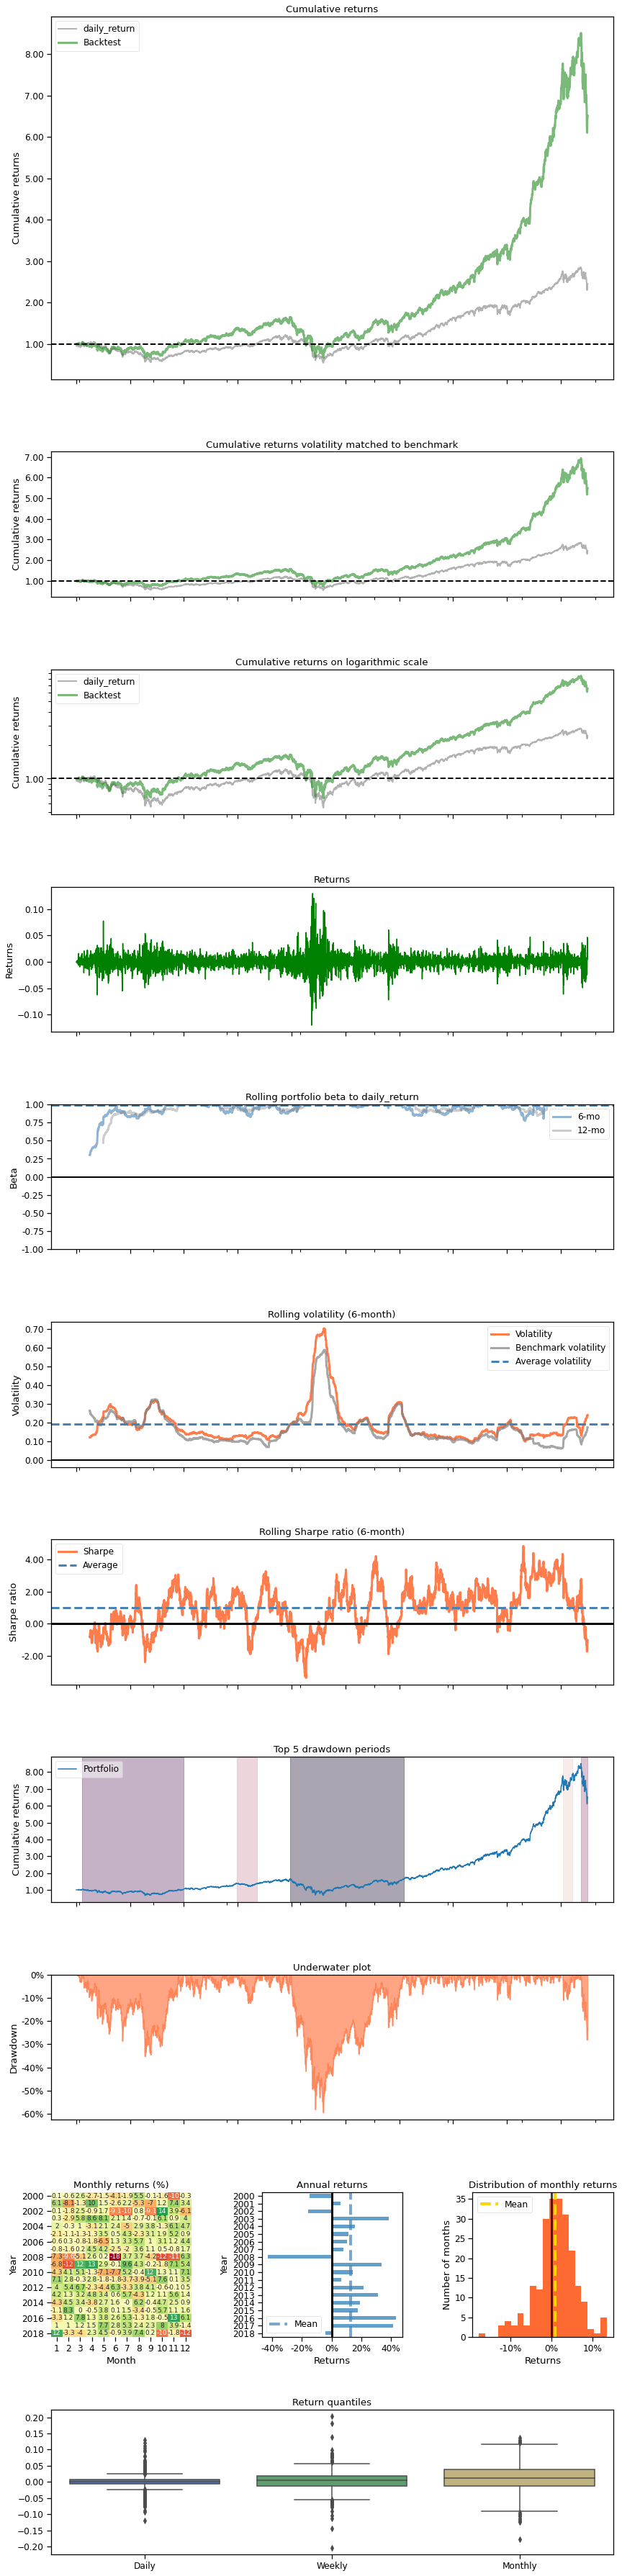

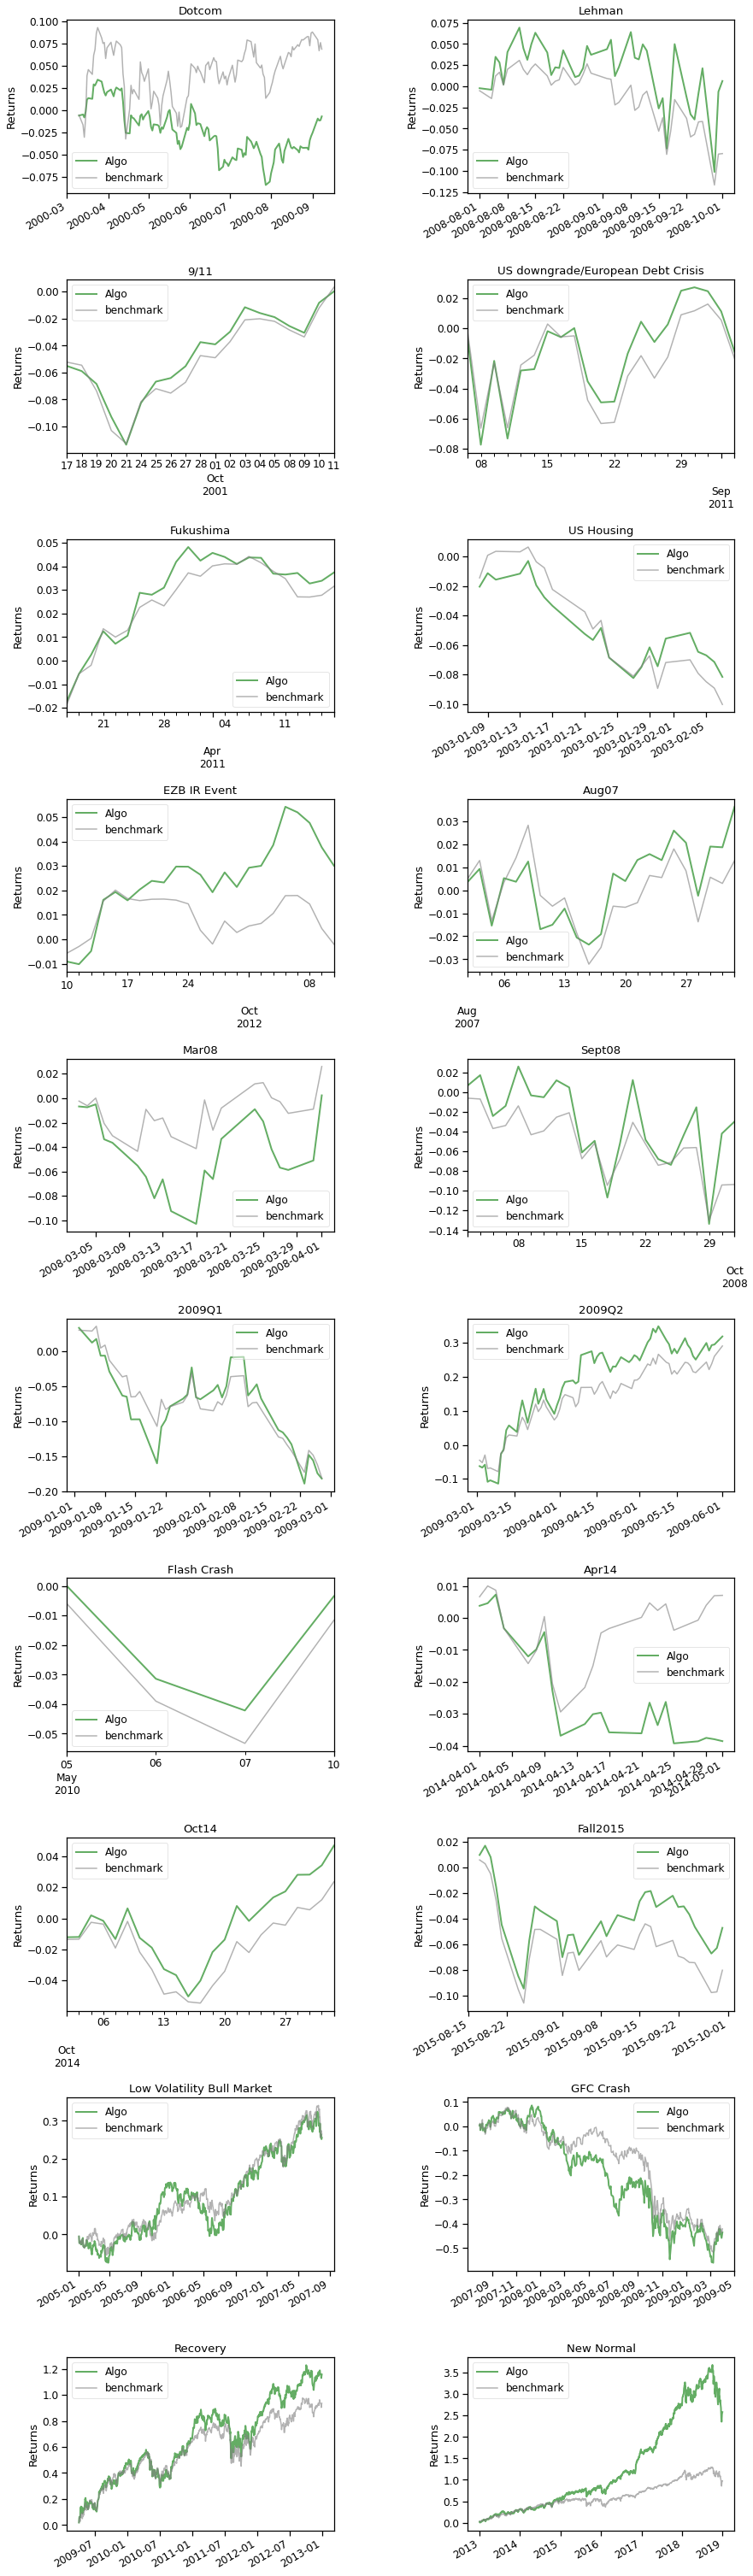

In [139]:
%matplotlib inline
backtest_plot(df_value['training_a2c'], baseline_ticker = 'SPY', baseline_start = start_date, baseline_end = split_date)

In [ ]:
%matplotlib inline
backtest_plot(df_value['training_ppo'], baseline_ticker = 'SPY', baseline_start = start_date, baseline_end = split_date)

In [ ]:
%matplotlib inline
backtest_plot(df_value['training_sac'], baseline_ticker = 'SPY', baseline_start = start_date, baseline_end = split_date)

In [ ]:
%matplotlib inline
backtest_plot(df_value['training_ddpg'], baseline_ticker = 'SPY', baseline_start = start_date, baseline_end = split_date)

In [ ]:
%matplotlib inline
backtest_plot(df_value['training_td3'], baseline_ticker = 'SPY', baseline_start = start_date, baseline_end = split_date)

### Evaluation Performance

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (505, 8)


Start date,2019-01-02
End date,2020-12-31
Total months,24
,Backtest
Annual return,18.725%
Cumulative returns,41.052%
Annual volatility,23.197%
Sharpe ratio,0.86
Calmar ratio,0.72
Stability,0.73
Max drawdown,-25.921%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,25.92,2020-02-19,2020-03-20,2020-08-18,130
1,10.00,2020-10-13,2020-11-02,NaT,NaN
2,8.27,2020-09-02,2020-09-23,2020-10-12,29
3,5.94,2019-05-03,2019-06-03,2019-06-19,34
4,3.04,2019-09-13,2019-09-27,2019-11-04,37


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:395: MatplotlibDeprecationWarning: 
The is_last_row function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_last_row() instead.
  if ax.is_last_row():
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:395: MatplotlibDeprecationWarning: 
The is_last_row function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_last_row() instead.
  if ax.is_last_row():
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:395: MatplotlibDeprecationWarning: 
The is_last_row function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_last_row() instead.
  if ax.is_last_row():
/Library/Frameworks/Py

Stress Events,mean,min,max
New Normal,0.08%,-10.99%,9.04%


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/indexes/base.py:5277: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  start_slice, end_slice = self.slice_locs(start, end, step=step, kind=kind)


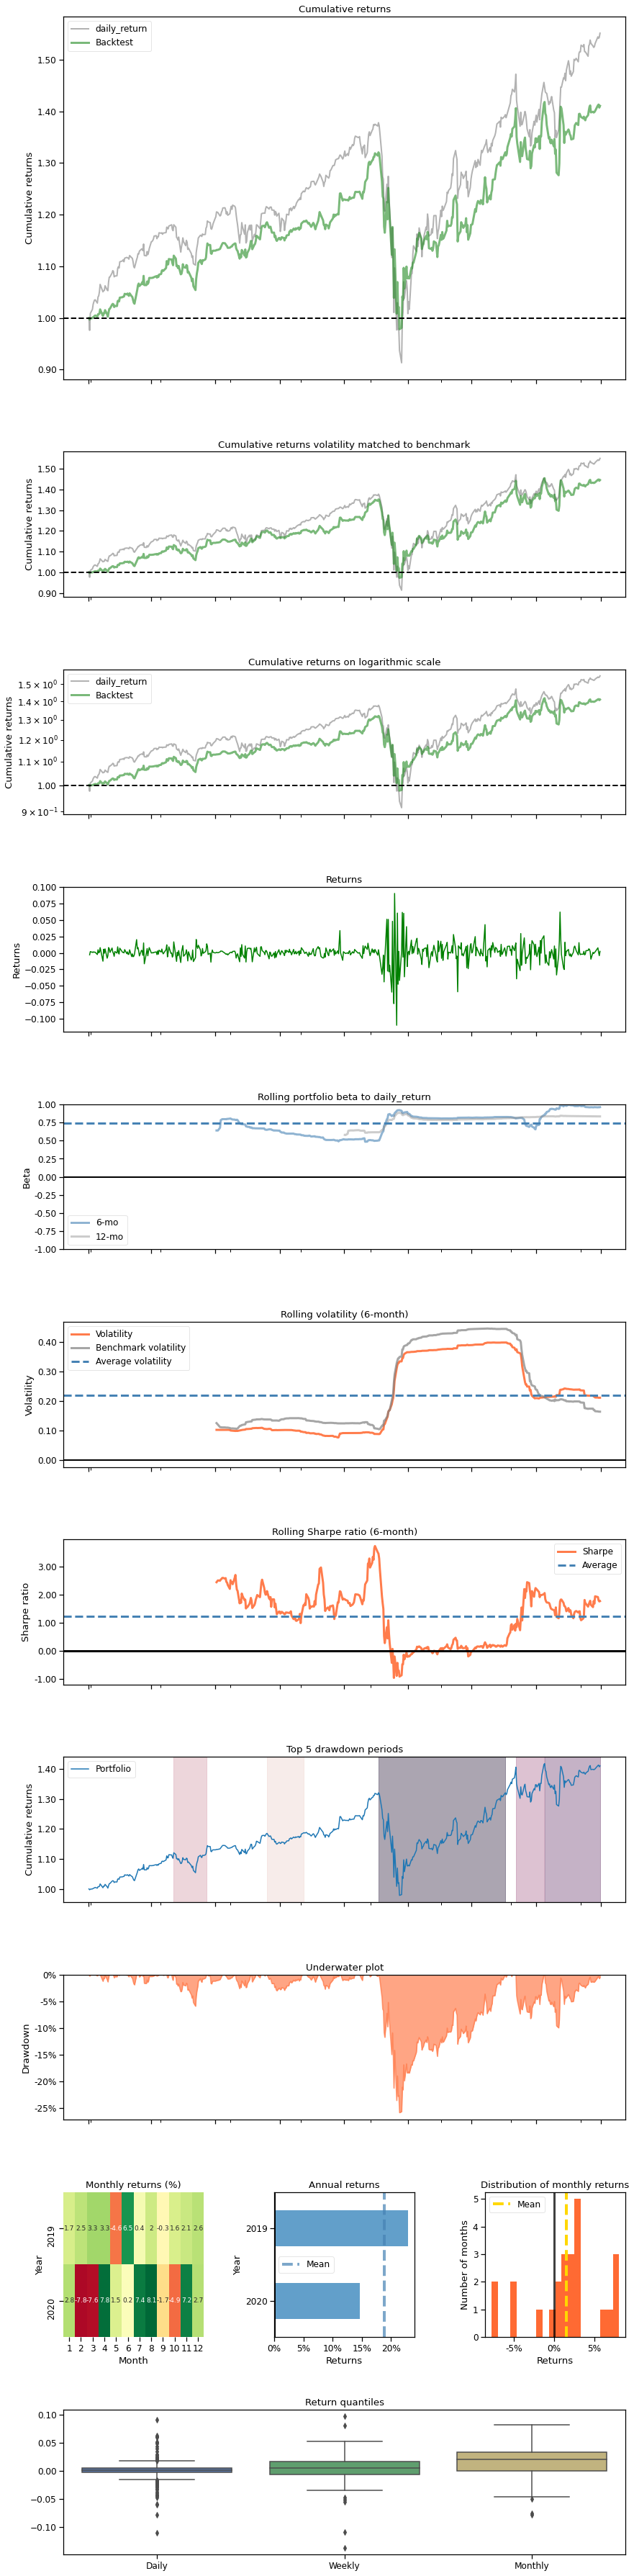

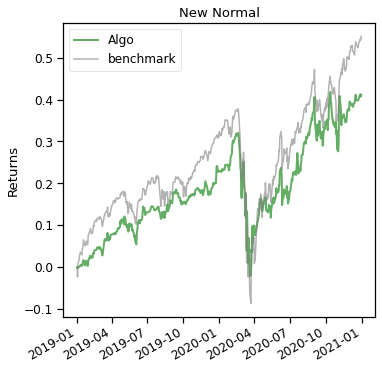

In [159]:
%matplotlib inline
backtest_plot(df_value['evaluation_a2c'], baseline_ticker = 'SPY', baseline_start = split_date, baseline_end = end_date)

In [ ]:
%matplotlib inline
backtest_plot(df_value['evaluation_ppo'], baseline_ticker = 'SPY', baseline_start = split_date, baseline_end = end_date)

In [ ]:
%matplotlib inline
backtest_plot(df_value['evaluation_sac'], baseline_ticker = 'SPY', baseline_start = split_date, baseline_end = end_date)

In [ ]:
%matplotlib inline
backtest_plot(df_value['evaluation_ddpg'], baseline_ticker = 'SPY', baseline_start = split_date, baseline_end = end_date)

In [ ]:
%matplotlib inline
backtest_plot(df_value['evaluation_td3'], baseline_ticker = 'SPY', baseline_start = split_date, baseline_end = end_date)